# CMSC320 Final Project


#Steam Game Data Analysis
Spring 2025 Data Science Project

Simon Ambrozak, Shubham Bhatnagar, Meherzan Gai, Jude Lwin, and Brandon Kim

##Contributions:

All members contributed equally to brainstorming:
 - Choosing Project Idea
 - Choosing Machine Learning Algorithm

Simon Ambrozak
 - Prepared dataset files and converted them into csvs from the source
 - Created standardized dataframe that combined every data file
 - Began initial dataset exploration, generated graphs on game price vs. release date
 - Performed 1st test to see if release date was correlated with initial price
 - Interpreted ML results
 - Prepared & published website

Meherzan Gai
 - Curated data
 - Converted missing/null data to NaNs and imputed/removed missing values
 - Unpacked the prices column into multiple columns containing, the initial price, final price, discount markdown, and currency used
 - Utilized the currency converter library to convert all prices to USD
 - Cleaned data by removing HTML tags from them
 - Converted values to the correct data type (dates to datetimes, numbers to integers, etc)

Shubham Bhatnagar
 - Did preliminary research on possible datasources to use for the project
 - Worked on dataset exploration, generated graphs on distribution of review scores for free vs paid games
 - Analyzed ML model output to determine effectiveness

Brandon Kim
 - Worked on cleaning data for new columns
 - Fixed NaN and preprocessed df for streamspy data
 - Ingested sales count data
 - Modeled and visualized alternative ML models

Jude Lwin
  - Performed 3rd statistical method of EDA
  - Finalized chosen machine learning algorithm
  - Implemented filtering of free games
  - Coded training, prediction, and evaluation of model
  - Implemented visualization of model predictions

# Introduction

For our data analysis project, we chose Steam game data. Steam is popular platform for developers to post their games for consumers to buy. We chose this because the video game industry is ruthless, complex, and difficult to succeed in. By using data vis and machine learning, we hope to provide some insight on how games are priced.

Price points for games are difficult to decide on for developers, and recently have become a hot topic for consumers. Nintedo raising the price on its games from \$60 to \$80 has caused outrage in their community.

If we can help companies see some of the successes and failures in game pricing, hopefully they could use our analysis to better price their products.


# Data Source

For this project, we used this data source from github:
https://github.com/NewbieIndieGameDev/steam-insights

Created by: NewbieIndieGameDev (https://github.com/NewbieIndieGameDev)

This is a collection of data pulled down from the Steam marketplace that has data for every game including: Release date, price, ratings, languages, genres, community tags, etc.

In [ ]:
!pip install pandas numpy matplotlib seaborn scipy tqdm currency_converter currencyconverter

# Data Curation


In [ ]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import re
from tqdm import tqdm
import json
from currency_converter import CurrencyConverter
from scipy.stats import ttest_ind


In [ ]:
# Merge the simple CSVs based on app_id
gamesdf = pd.read_csv("./games.csv", quotechar='"', escapechar='\\', dtype="str")
genresdf = pd.read_csv("./genres.csv", quotechar='"', escapechar='\\', dtype="str")
gamesdf = pd.merge(gamesdf, genresdf, on="app_id")
reviewsdf = pd.read_csv("./reviews.csv", quotechar='"', escapechar='\\', dtype="str")
gamesdf = pd.merge(gamesdf, reviewsdf, on="app_id")
descriptionsdf = pd.read_csv("./descriptions.csv", quotechar='"', escapechar='\\', dtype="str")
gamesdf = pd.merge(gamesdf, descriptionsdf, on="app_id")
insightsdf = pd.read_csv("./steamspy_insights.csv", quotechar='"', escapechar='\\', dtype="str")
insightsdf = insightsdf[["app_id", "owners_range"]]  # Only keep necessary columns
gamesdf = pd.merge(gamesdf, insightsdf, on="app_id", how="left")

In [ ]:
### NA values are written as 'N'. Let us fix this below
# print(gamesdf.head(10))
print(gamesdf.columns)
gamesdf = gamesdf.map(lambda x: np.nan if x == "N" else x)


### The languages column has <strong> tags around * symbols in it sometimes. Let's get rid of these.

gamesdf["languages"] = gamesdf["languages"].str.replace("<strong>*</strong>", "")


### Those asterixes correspond to having full audio support for those languages.
# We don't really care about this so let's get rid of that too
gamesdf["languages"] = gamesdf["languages"].str.replace("<br>languages with full audio support", "")


### Used to check if values are converted correctly. No rows should display if all values with 'N' are properly converted to NaN
# matches = gamesdf == 'N'
# display(gamesdf[matches.any(axis=1)])





Index(['app_id', 'name', 'release_date', 'is_free', 'price_overview',
       'languages', 'type', 'genre', 'review_score',
       'review_score_description', 'positive', 'negative', 'total',
       'metacritic_score', 'reviews', 'recommendations', 'steamspy_user_score',
       'steamspy_score_rank', 'steamspy_positive', 'steamspy_negative',
       'summary', 'extensive', 'about', 'owners_range'],
      dtype='object')


In [ ]:
# The owners range column is poorly formatted, with several with just incoherent data. Also the format is not quantifiable and is dtype object
import re

# Keep only rows where owners_range matches the expected pattern
pattern = r'^\d{1,3}(,\d{3})* .. \d{1,3}(,\d{3})*$'
display(gamesdf['owners_range'])
gamesdf = gamesdf[gamesdf['owners_range'].str.match(pattern, na=False)]

owners_split = gamesdf['owners_range'].str.replace(',', '').str.split(' .. ', expand=True)
gamesdf['owners_min'] = owners_split[0].astype(int)
gamesdf['owners_max'] = owners_split[1].astype(int)

,owners_range
0,"10,000,000 .. 20,000,000"
1,"5,000,000 .. 10,000,000"
2,"5,000,000 .. 10,000,000"
3,"5,000,000 .. 10,000,000"
4,"2,000,000 .. 5,000,000"
...,...
353334,"0 .. 20,000"
353335,"0 .. 20,000"
353336,"0 .. 20,000"
353337,"0 .. 20,000"


In [ ]:
### Some columns aren't typed properly. For example is_free is typed as an object instead of a boolean.

# Let's convert the release date to datetimes
gamesdf["release_date"] = pd.to_datetime(gamesdf["release_date"])

# Now let's convert the is_free column. It uses 0's and 1's to represent false or true respectively
# Let's map that to a boolean
gamesdf["is_free"] = gamesdf["is_free"].apply(lambda x : False if x == '0' else True)


# Let's convert the languages into a list of of strings
gamesdf["languages"] = gamesdf["languages"].str.split(",")




### Let's convert the following columns to integers
toIntegerColumnNames = []

# Let's convert the review scores as well as the positive, negative, and total review counts to integers
toIntegerColumnNames.append("review_score")
toIntegerColumnNames.append("positive")
toIntegerColumnNames.append("negative")
toIntegerColumnNames.append("total")

# Let's convert the metacritic scores to integers too
toIntegerColumnNames.append("metacritic_score")

# Let's convert the recommendation counts to integers
toIntegerColumnNames.append("recommendations")


# Let's convert the steamspy user scores, score ranks, positive review counts, and negative review counts to integers
toIntegerColumnNames.append("steamspy_user_score")
toIntegerColumnNames.append("steamspy_score_rank")
toIntegerColumnNames.append("steamspy_positive")
toIntegerColumnNames.append("steamspy_negative")


# Okay let's convert all of these to integers now! :)
for columnName in toIntegerColumnNames:
    gamesdf[columnName] = gamesdf[columnName].apply(lambda x: int(x) if pd.notna(x) else x)

# lots of weird data in the review_score col, filters out anything that isnt between 0 and 10
gamesdf = gamesdf[
    gamesdf['review_score'].apply(lambda x: isinstance(x, (int, float)) and float(x).is_integer() and 0 <= int(x) <= 10)
]


# display(gamesdf.head()) #checking work
# print(gamesdf.dtypes) #checking work

In [ ]:
### Unpacking the price_overview column

#Note that I divide these prices by 100 since they don't have appropriate decimals (i.e. 819 = $8.19)
gamesdf["final_price"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["final"]/100 if pd.notna(x) else x)
gamesdf["initial_price"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["initial"]/100 if pd.notna(x) else x)
gamesdf["currency"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["currency"] if pd.notna(x) else x)
gamesdf["discount_percent"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["discount_percent"] if pd.notna(x) else x)


print(gamesdf["currency"].unique())
print(gamesdf["discount_percent"].unique())

['EUR' 'MXN' nan 'RUB' 'USD' 'CAD' 'BRL' 'SAR' 'GBP' 'PEN' 'ILS' 'KRW'
 'UAH' 'INR' 'PHP' 'IDR' 'PLN' 'COP' 'AUD' 'NZD' 'SGD' 'THB' 'CNY' 'KWD'
 'KZT' 'MYR' 'TWD' 'JPY' 'AED' 'HKD' 'VND' 'NOK']
[ 0. nan 80. 67. 85. 90. 70. 86. 89. 65. 75. 60. 50. 76. 78. 55. 72. 66.
 30. 87. 95. 83. 92. 68. 51. 84. 91. 88. 35. 20. 82. 25. 61. 40. 24. 49.
 59. 57. 52. 64. 81. 77. 10. 79. 33. 45. 15. 73. 56. 53. 94. 37. 39. 31.
 34. 63. 44. 46. 93. 26. 42. 69. 54. 22. 47. 43. 71. 27. 38. 48. 62. 17.
 21. 19. 29. 18. 32. 58. 11. 36. 41. 12. 28.]


In [ ]:
### Converting all prices to USD
unique_currencies = gamesdf["currency"].dropna().unique()

conversion_rates = {}

converter = CurrencyConverter(fallback_on_missing_rate=True)
for currency in unique_currencies:
        if currency != 'USD':
            try:
                conversion_rates[currency] = converter.convert(1, currency, 'USD')
            except: #in case anything ever goes wrong with the library
                conversion_rates[currency] = None


#### WARNING: THESE NEXT FEW CURRENCIES ARE MANUALLY BEING UPDATED

## Inputing conversion rates for currencies that don't have one (taken from wise.com)
conversion_rates["SAR"] = 0.2666
conversion_rates["PEN"] = 0.2726
conversion_rates["UAH"] = 0.02433
conversion_rates["COP"] = 0.0002413
conversion_rates["KWD"] = 3.243
conversion_rates["KZT"] = 0.001986
conversion_rates["TWD"] = 0.03011
conversion_rates["AED"] = 0.2723
conversion_rates["VND"] = 0.00003902

for currency, rate in conversion_rates.items():
        currency_rows = (gamesdf['currency'] == currency) #find all rows with this currency
        gamesdf.loc[currency_rows, "currency"] = "USD" #set the currencies to usd now
        gamesdf.loc[currency_rows, "initial_price"] = (gamesdf.loc[currency_rows, "initial_price"] * rate) #convert the initial prices
        gamesdf.loc[currency_rows, "final_price"] = (gamesdf.loc[currency_rows, "final_price"] * rate) #convert the final prices


### Rounding the prices to two decimals
gamesdf["initial_price"] = gamesdf["initial_price"].round(2) #rounding the initial prices
gamesdf["final_price"] = gamesdf["final_price"].round(2) #rounding the final prices

# Fixing free games
gamesdf.loc[gamesdf['final_price'].isna(), ['final_price', 'initial_price', 'currency']] = [0, 0, 'USD']

# Dropping rows without prices
gamesdf = gamesdf.dropna(subset=['final_price', 'initial_price'])



### TODO: Use some sort of imputation on missing values/figure out what to do with them

display(gamesdf)

,app_id,name,release_date,is_free,price_overview,languages,type,genre,review_score,review_score_description,...,summary,extensive,about,owners_range,owners_min,owners_max,final_price,initial_price,currency,discount_percent
0,10,Counter-Strike,2000-11-01,False,"{""final"": 819, ""initial"": 819, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,9.0,Overwhelmingly Positive,...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,"10,000,000 .. 20,000,000",10000000,20000000,9.09,9.09,USD,0.0
1,20,Team Fortress Classic,1999-04-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,8.0,Very Positive,...,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,"5,000,000 .. 10,000,000",5000000,10000000,5.54,5.54,USD,0.0
2,30,Day of Defeat,2003-05-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,8.0,Very Positive,...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,"5,000,000 .. 10,000,000",5000000,10000000,5.54,5.54,USD,0.0
3,40,Deathmatch Classic,2001-06-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,8.0,Very Positive,...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,"5,000,000 .. 10,000,000",5000000,10000000,5.54,5.54,USD,0.0
4,50,Half-Life: Opposing Force,1999-11-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Korean]",game,Action,9.0,Overwhelmingly Positive,...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,"2,000,000 .. 5,000,000",2000000,5000000,5.54,5.54,USD,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353334,3297890,Quantum of Hope Demo,NaT,True,NaN,[English],demo,Indie,0.0,1 user reviews,...,Simple and short top-down shooter game with a ...,"<p class=""bb_paragraph"">It's been two years si...","<p class=""bb_paragraph"">It's been two years si...","0 .. 20,000",0,20000,0.00,0.00,USD,NaN
353335,3298020,A Night With: Succubus,NaT,False,NaN,"[English, Spanish - Spain, Japanese, Portug...",game,Casual,0.0,No user reviews,...,An adult visual novel where your choices shape...,"<p class=""bb_paragraph""><i>A Night With: Succu...","<p class=""bb_paragraph""><i>A Night With: Succu...","0 .. 20,000",0,20000,0.00,0.00,USD,NaN
353336,3298020,A Night With: Succubus,NaT,False,NaN,"[English, Spanish - Spain, Japanese, Portug...",game,RPG,0.0,No user reviews,...,An adult visual novel where your choices shape...,"<p class=""bb_paragraph""><i>A Night With: Succu...","<p class=""bb_paragraph""><i>A Night With: Succu...","0 .. 20,000",0,20000,0.00,0.00,USD,NaN
353337,3298020,A Night With: Succubus,NaT,False,NaN,"[English, Spanish - Spain, Japanese, Portug...",game,Simulation,0.0,No user reviews,...,An adult visual novel where your choices shape...,"<p class=""bb_paragraph""><i>A Night With: Succu...","<p class=""bb_paragraph""><i>A Night With: Succu...","0 .. 20,000",0,20000,0.00,0.00,USD,NaN


# Exploratory data analysis

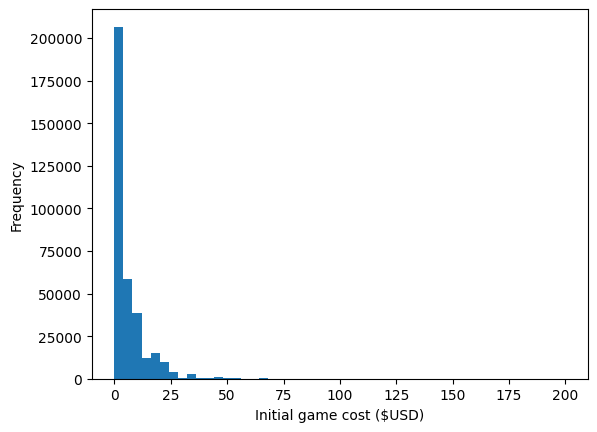

In [ ]:
### Now we can begin with simple price analyses
# First create a histrogram with all prices

# Filter out outlier prices
prices = [x for x in gamesdf["initial_price"].dropna() if x < 200]
plt.hist(prices, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Initial game cost ($USD)")
plt.show()

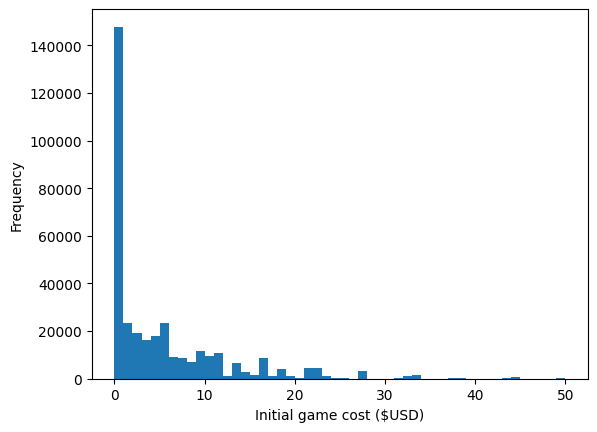

In [ ]:
# Let's get a better look at the main peak of the distribution
prices = [x for x in gamesdf["initial_price"].dropna() if x < 50]
plt.hist(prices, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Initial game cost ($USD)")
plt.show()

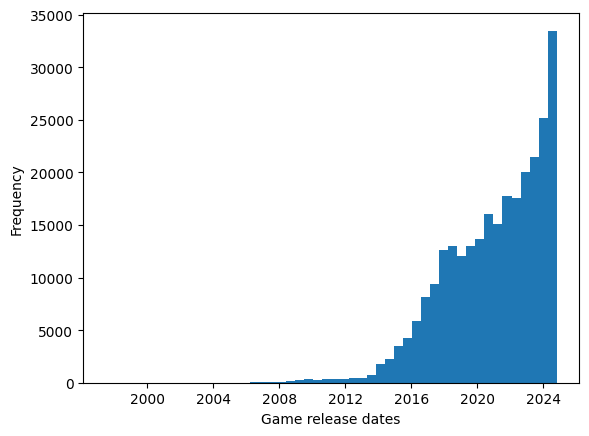

In [ ]:
### Now plot games by release date
dates = gamesdf["release_date"].dropna()
plt.hist(dates, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Game release dates")
plt.show()

Text(0.5, 1.0, 'Game release date vs. Initial Price')

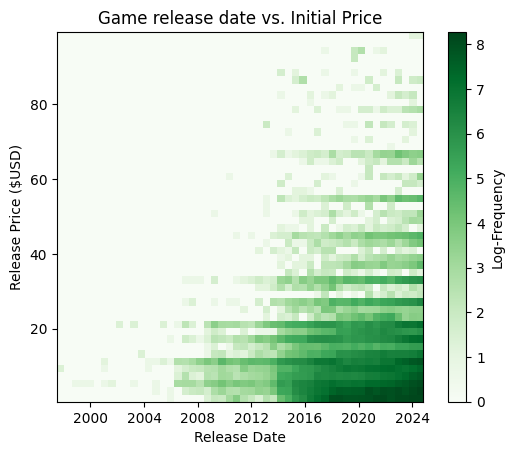

In [ ]:
### Now let's see if there's a trend between game cost and release date
### Expected: game prices increase over time due to inflation
filteredgamesdf = gamesdf.dropna(subset=["release_date", "initial_price"])
filteredgamesdf = filteredgamesdf[filteredgamesdf["initial_price"] < 100]
filteredgamesdf = filteredgamesdf[filteredgamesdf["initial_price"] != 0] #Uncomment this line to remove free games from the distribution
date_min, date_max = min(filteredgamesdf["release_date"]), max(filteredgamesdf["release_date"])
price_min, price_max = min(filteredgamesdf["initial_price"]), max(filteredgamesdf["initial_price"])
heatmap, x_edges, y_edges = np.histogram2d(filteredgamesdf["release_date"], filteredgamesdf["initial_price"], bins=50)

# Apply log transformation to improve visibility
heatmap_log = np.log1p(heatmap)  # log(1 + x) to handle zeros

#plt.imshow(heatmap.T, origin='lower', cmap='hot', aspect=(x_max / y_max), extent=[x_min, x_max, y_min, y_max])
plt.imshow(heatmap_log.T, origin='lower', cmap='Greens', aspect=(date_max.year / price_max)*5, extent=[date_min, date_max, price_min, price_max])
plt.colorbar(label='Log-Frequency')
plt.xlabel('Release Date')
plt.ylabel('Release Price ($USD)')
plt.title('Game release date vs. Initial Price')

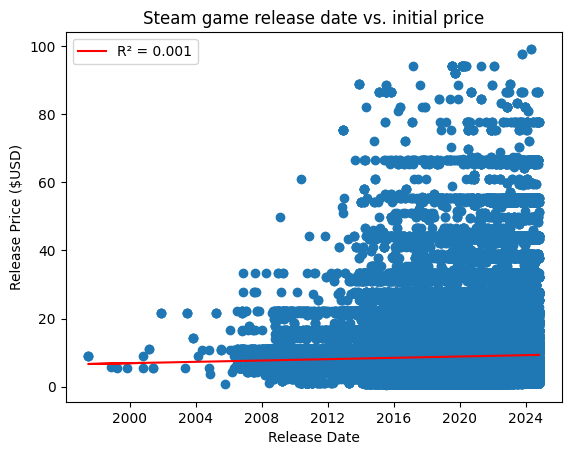

Index(['app_id', 'name', 'release_date', 'is_free', 'price_overview',
       'languages', 'type', 'genre', 'review_score',
       'review_score_description', 'positive', 'negative', 'total',
       'metacritic_score', 'reviews', 'recommendations', 'steamspy_user_score',
       'steamspy_score_rank', 'steamspy_positive', 'steamspy_negative',
       'summary', 'extensive', 'about', 'owners_range', 'owners_min',
       'owners_max', 'final_price', 'initial_price', 'currency',
       'discount_percent'],
      dtype='object')


In [ ]:
x = filteredgamesdf["release_date"].map(lambda d: d.toordinal())
y = filteredgamesdf["initial_price"]

# Linear regression
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)
line = slope * x + intercept  # Predicted values

# Plot
plt.scatter(filteredgamesdf["release_date"], y)
plt.plot(filteredgamesdf["release_date"], line, color='red', label=f"R² = {r_value**2:.3f}")

plt.xlabel("Release Date")
plt.ylabel("Release Price ($USD)")
plt.title(f"Steam game release date vs. initial price")
plt.legend()
plt.show()
print(filteredgamesdf.columns)


### TODO: Add r-squared pearson test to this and line of best fit, this can be our first hypothesis test

### Test 1
Because the correlation coefficient is very low, we see that there is no signifigant influence on a game's price based on the year it was released.
We do see that the general maximum game price increases, particularly from 2008 to 2016, but the average price does not increase.

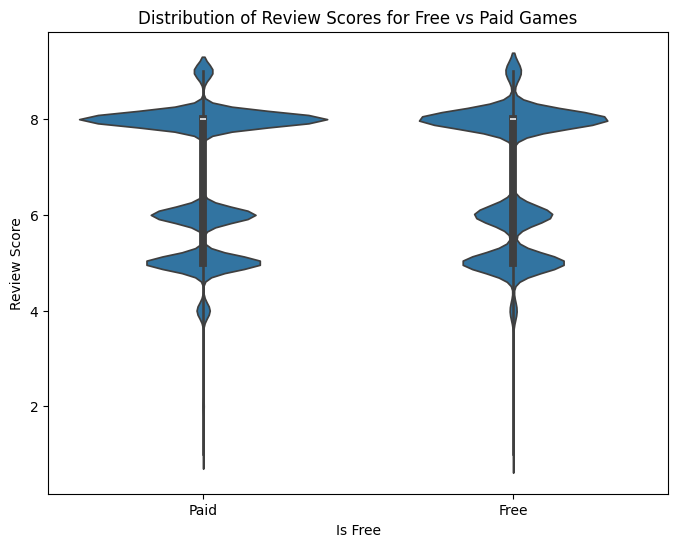

T-statistic: -1.7298827368208565, P-value: 0.08366030602059721
The difference in review scores between free and paid games is not statistically significant.


In [ ]:
# Is there a signficant difference in in review scores between free and paid games?

review_threshold = 50  # Minimum number of reviews to consider

filtered_games = gamesdf[gamesdf["total"] >= review_threshold]

# Get the dfs for review scores for free and paid games
free_games = filtered_games[filtered_games["is_free"] == True]["review_score"].dropna()
paid_games = filtered_games[filtered_games["is_free"] == False]["review_score"].dropna()

# Perform the t-test
t_stat, p_value = ttest_ind(free_games, paid_games, equal_var=False)

# Create a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x=filtered_games["is_free"], y=filtered_games["review_score"])
plt.xlabel("Is Free")
plt.ylabel("Review Score")
plt.title("Distribution of Review Scores for Free vs Paid Games")
plt.xticks(ticks=[0, 1], labels=["Paid", "Free"])
plt.show()

# Output t-test results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The difference in review scores between free and paid games is statistically significant.")
else:
    print("The difference in review scores between free and paid games is not statistically significant.")

### Test 2
For examining the difference in rating scores between free and paid games, we used a 2-sample T-test. Because the P-value we got is 0.08, (above the critical value 0.05), we see no signifigant difference between free and paid game reviews.

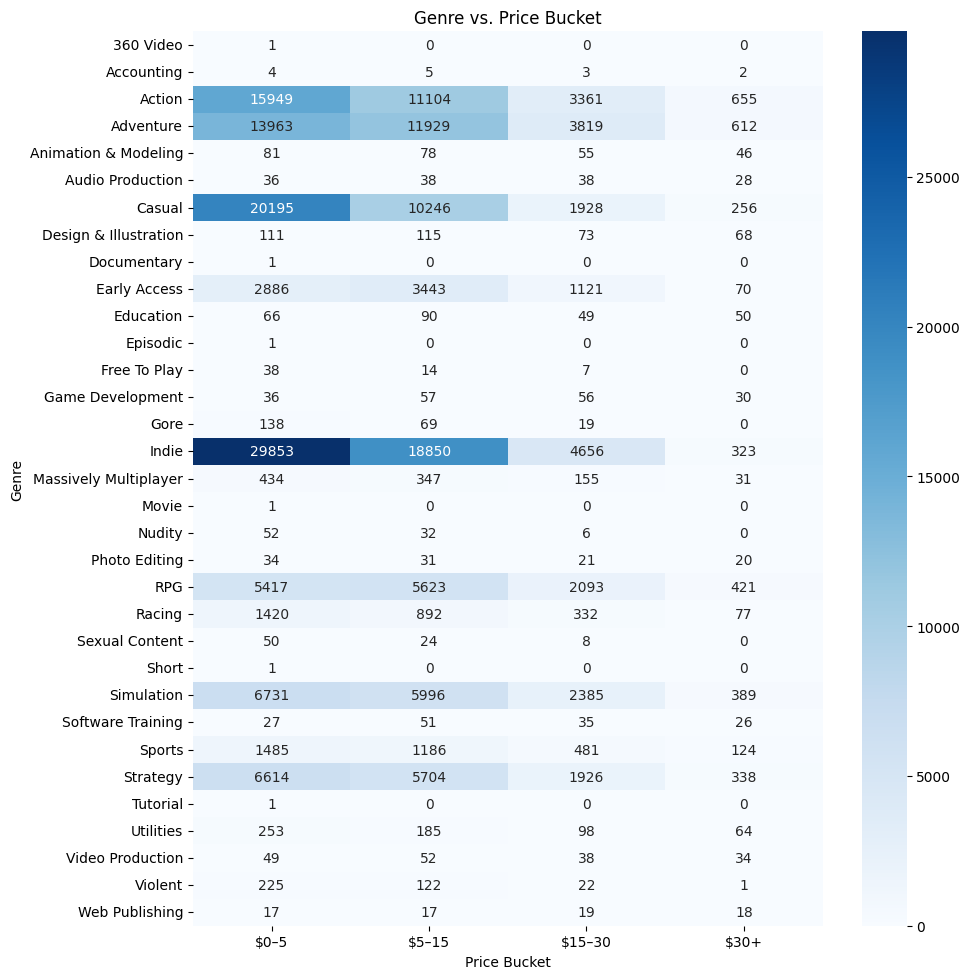

{'chi2_statistic': np.float64(9154.910864669984),
 'p_value': np.float64(0.0),
 'degrees_of_freedom': 96}

In [ ]:
filteredgamesdf["price_overview"] = filteredgamesdf["price_overview"].apply(json.loads)
filteredgamesdf["initial_price_dollars"] = filteredgamesdf["price_overview"].apply(lambda d: d.get("initial", 0) / 100)

# Define price bucket categories in dollars
def price_bucket_dollars(price):
    if price == 0:
        return "Free"
    elif price <= 5:
        return "$0–5"
    elif price <= 15:
        return "$5–15"
    elif price <= 30:
        return "$15–30"
    else:
        return "$30+"

# Apply price buckets
filteredgamesdf["price_bucket"] = filteredgamesdf["initial_price_dollars"].apply(price_bucket_dollars)

# Set price bucket order for plotting
price_order = ["Free", "$0–5", "$5–15", "$15–30", "$30+"]
filteredgamesdf["price_bucket"] = pd.Categorical(
    filteredgamesdf["price_bucket"],
    categories=price_order,
    ordered=True
)

# Create contingency table
contingency = pd.crosstab(filteredgamesdf["genre"], filteredgamesdf["price_bucket"])

# Chi-square test
chi2, p, dof, expected = sp.stats.chi2_contingency(contingency)

# Plot heatmap
plt.figure(figsize=(10, len(contingency) * 0.3))
sns.heatmap(contingency, annot=True, fmt="d", cmap="Blues")
plt.title("Genre vs. Price Bucket")
plt.xlabel("Price Bucket")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Output results
chi2_test_result = {
    "chi2_statistic": chi2,
    "p_value": p,
    "degrees_of_freedom": dof
}

chi2_test_result



### Test 3
This chi squared test shows us that there is a statistically significant relationship between game genre and price tier as the p value ended up being 0.0 which is
clearly less than an alpha value of 0.05. This makes sense as in general certain genres of games tend to be priced lower or higher.

#Primary Analysis and Vizualiation


We decided to use regression to model how a game's launch performance might relate to its price.

Clustering would not give us a good picture of our data, since there are no clear groups and based on our background knowledge, games exist on a wide spectrum.

Classification also isn't useful, unless we wanted to predict free vs. paid games, which could be another interesting question to answer, but not what we're focusing on.

RMSE: $7.06
R² score: 0.23


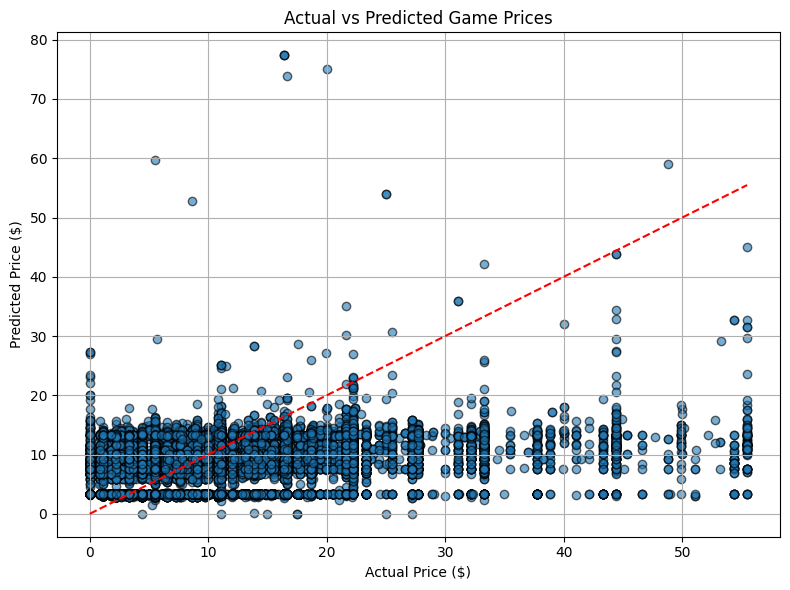

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Columns to use as features
feature_cols = [
    "discount_percent", "positive", "negative", "total",
    "recommendations", "review_score", "metacritic_score",
    "steamspy_user_score", "steamspy_score_rank",
    "steamspy_positive", "steamspy_negative"
]

# Filter out free games
paid_games = gamesdf[gamesdf["is_free"] == False].copy()
# Remove rows with missing price
paid_games = paid_games[paid_games["initial_price"].notna()]
paid_games["initial_price"] = paid_games["initial_price"].astype(float)

# Remove extreme price outliers using 1st and 99th percentiles
low, high = paid_games["initial_price"].quantile([0.01, 0.99])
paid_games = paid_games[(paid_games["initial_price"] >= low) & (paid_games["initial_price"] <= high)]


# Drop rows where initial_price is missing
paid_games = paid_games[paid_games["initial_price"].notna()]

# Prepare X and y
X = paid_games[feature_cols]
y = paid_games["initial_price"].astype(float)

# Impute and scale
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge regression (handles multicollinearity)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
# Apply ReLU to prevent negative price predictions
y_pred = np.maximum(0, y_pred)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: ${rmse:.2f}")
print(f"R² score: {r2:.2f}")


import matplotlib.pyplot as plt

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # y = x line
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Game Prices")
plt.grid(True)
plt.tight_layout()
plt.show()


#Insights and Conclusions

We wanted to ask the question: Given how well a game performed, e.g. its ratings, sales, and other features, can you predict how much it initially cost?

This would be valuable information because if a company can outline goals for a video game's performance, they could use machine learning to benchmark how much it should cost.

Here's an exmaple:

Let's say a company wants to make a massively-multiplayer online game, that has 10,000 in sales, with mostly positive ratings. How much should they charge for it? Machine learning could give valuable insight when answering this question. Charge too much, and people won't be happy with or buy the game. Too little, and the company won't get the profit they're looking for.

Of course, there are many factors we're not considering, such as development cost, but we're working with the data we have.

Examining the performance of our Ridge regression model, we can see that the RMSE of predictions is $7, which isn't horrible, but could certainly be better.

It's apparent that our model could be signifigantly improved by looking at the correlation coefficient between actual vs. predicted price: 0.23. This suggests that there's much more to picking a price point than the features we have in our dataset, and companies should consider more than just their launch performance goals. For example, development cost, development time, social media sentiment analysis, market competition analysis, etc.

The video game market is volatile, and tough to succeed in. Even with limited data, our results show that machine learning can be used to provide some insight into the industry.